# Tensorflow Setup and Utility Functions

This notebook provides essential functions for setting up a Tensorflow Environment, loading and preprocessing image datasets, and visualizing the data. It's designed to be flexible and adaptable to various directory structures and image formats.

## Imports

- **tensorflow (tf)**: The main library for machine learning operations.
- **numpy (np)**: A library for numerical operations on large, multi-dimensional arrays and matrices.
- **matplotlib.pyplot (plt)**: A library for creating visualizations.
- **seaborn (sns)**: A library for creating more attractive visualizations.
- **pandas (pd)**: A library for data manipulation and analysis.
- **time**: A library for working with time and measuring performance.
- **pathlib.Path**: Provides an object-oriented interface for working with filesystem paths.
- **typing**: A library for type hints and annotations.
- **datetime**: A library for working with dates and times.
- **tqdm**: A library for creating interactive progress bars.
- **sklearn**: A library for machine learning operations.

## GPU Functions

The following functions are used to set up the Tensorflow environment and check for the presence of a GPU.


In [93]:
import warnings
import os
import logging

In [94]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.FATAL)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

warnings.filterwarnings("ignore")

In [95]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, List, Dict, Optional
from datetime import datetime
from sklearn.manifold import TSNE

### Tensorflow Auxiliary Functinons and Configuration


In [96]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.18.0


In [97]:
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

Built with CUDA: True


### Setting Up GPU Configuration


In [98]:
from dataclasses import dataclass, field

In [99]:
@dataclass
class MemoryConfig:
    max_memory_gb: float = 8.0
    batch_size: int = 32
    prefetch_buffer: int = 2
    cache_dataset: bool = True
    mixed_precision: bool = True
    memory_growth: bool = True

In [100]:
def setup_gpu() -> Tuple[tf.distribute.Strategy, int]:
    """
    Set up a GPU strategy for tensorflow.

    This function does the following
    1. Detects available GPUs.
    2. Sets up an appropriate strategy for the available GPUs.
    3. Returns the strategy and number of GPUs available.

    This function handles three cases:
    - No GPUs: returns a default strategy using CPU.
    - Single GPU: returns a MirroredStrategy with a single device.
    - Multiple GPUs: returns a MirroredStrategy with all available devices.

    Returns:
      tuple: (tf.distribute.Strategy, int) where the first element is the strategy and the second element is the number of GPUs available.
    """

    gpus = tf.config.list_physical_devices("GPU")
    num_gpus = len(gpus)

    if num_gpus == 0:
        print(f"No GPUs detected. Running on CPU.")
        print(f"Devices: {tf.config.list_physical_devices('CPU')}")
        print(f"Logical devices: {tf.config.list_logical_devices('CPU')}")

        return tf.distribute.get_strategy(), 0

    elif num_gpus == 1:
        print(f"1 GPU detected: {gpus[0].name}")
        print(tf.config.experimental.get_device_details(gpus[0]))

        return tf.distribute.OneDeviceStrategy(device="/gpu:0"), 1

    else:
        print(f"{num_gpus} GPUs detected: {[gpu.name for gpu in gpus]}")
        print([tf.config.experimental.get_device_details(gpu) for gpu in gpus])

        return tf.distribute.MirroredStrategy(), num_gpus

In [101]:
strategy, num_gpus = setup_gpu()

1 GPU detected: /physical_device:GPU:0
{'compute_capability': (8, 6), 'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU'}


In [102]:
def setup_tensorboard():
    """
    Setup a TensorBoard for visualization. To view the TensorBoard, run the following command in the terminal:
    tensorboard --logdir logs/scalars
    """

    logdir = "logs/scalars" + datetime.now().strftime("%Y%m%d-%H%M%S")
    file_writer = tf.summary.create_file_writer(str(logdir + "/metrics"))
    file_writer.set_as_default()

    print(f"TensorBoard logs will be saved to: {logdir}")

In [103]:
def benchmark_data_pipeline(dataset: tf.data.Dataset):
    """
    Benchmark the data pipeline to ensure efficient data loading.

    Args:
      dataset (tf.data.Dataset): Dataset to benchmark.
    """

    start_time = time.time()
    for _ in tqdm(dataset, desc="Benchmarking data pipeline"):
        pass

    end_time = time.time()
    print(f"Data pipeline benchmark: {end_time - start_time:.2f} seconds")

### Auxiliary Functions


In [104]:
def load_dataset(
    data_path: str,
    img_size: Tuple[int, int] = (224, 224),
    batch_size: int = 32,
    val_split: float = 0.1,
    test_split: float = 0.1,
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset, List[str]]:
    """
    Load and preprocess data using tf.data API with internal splits.

    Args:
        data_path (str): Path to data directory
        img_size (tuple): Image size to resize to
        batch_size (int): Batch size
        val_split (float): Validation split ratio
        test_split (float): Test split ratio

    Returns:
        tuple: (train_ds, val_ds, test_ds, class_names)
    """

    full_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        seed=123,
        image_size=img_size,
        batch_size=None,
    )

    dataset_size = len(full_ds)
    class_names = full_ds.class_names

    val_size = int(val_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - val_size - test_size

    train_ds = full_ds.take(train_size)
    temp_ds = full_ds.skip(train_size)
    val_ds = temp_ds.take(val_size)
    test_ds = temp_ds.skip(val_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.batch(batch_size).cache().shuffle(1000).prefetch(AUTOTUNE)
    val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
    test_ds = test_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names

In [105]:
def load_best_model(model_path: str) -> tf.keras.Model:
    """
    Load the best model from a given path.

    Args:
      model_path (str): Path to the model directory.

    Returns:
      tf.keras.Model: Model loaded from the given path.
    """

    best_model_path = Path(model_path) / "best_model.keras"
    return tf.keras.models.load_model(str(best_model_path))

## Data Augmentation


In [106]:
class DataAugmentation(tf.keras.layers.Layer):
    def __init__(self, img_size: Tuple[int, int] = (224, 224), p: float = 0.8):
        super(DataAugmentation, self).__init__()
        self.img_size = img_size
        self.p = p

    @tf.function
    def normalize_image(self, image):
        image = tf.cast(image, tf.float32)
        return tf.clip_by_value(image / 255.0, 0.0, 1.0)

    @tf.function
    def augment_single_image(self, image):
        # Random brightness
        prob_brightness = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_brightness < 0.8,
            lambda: tf.clip_by_value(tf.image.adjust_brightness(image, 0.2), 0.0, 1.0),
            lambda: image,
        )

        # Random contrast
        prob_contrast = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_contrast < 0.8,
            lambda: tf.clip_by_value(tf.image.adjust_contrast(image, 1.5), 0.0, 1.0),
            lambda: image,
        )

        # Random flip
        prob_flip = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_flip < 0.5, lambda: tf.image.flip_left_right(image), lambda: image
        )

        # Random noise
        prob_noise = tf.random.uniform(shape=[], minval=0.0, maxval=1.0)
        image = tf.cond(
            prob_noise < 0.3,
            lambda: tf.clip_by_value(
                image + tf.random.normal(tf.shape(image), mean=0.0, stddev=0.01),
                0.0,
                1.0,
            ),
            lambda: image,
        )

        return image

    @tf.function
    def call(self, inputs):
        # Normalize images
        images = self.normalize_image(inputs)

        # Augment images only in training mode
        images = tf.cond(
            tf.random.uniform(shape=[], minval=0.0, maxval=1.0) < self.p,
            lambda: tf.map_fn(self.augment_single_image, images),
            lambda: images,
        )

        return images

### Visualization Functions


In [107]:
def visualize_data_augmentation(
    dataset, data_augmentation, num_images=3, num_augmentations=4, figsize=(15, 5)
):
    """
    Visualize the effects of data augmentation on images from the dataset.
    """
    # Get sample images

    sample_images = []
    for images, _ in dataset.take(1):
        for i in range(min(num_images, len(images))):
            sample_images.append(images[i])

    # Create figure
    plt.figure(figsize=figsize)

    for i, original_image in enumerate(sample_images):
        # Show original image
        plt.subplot(num_images, num_augmentations + 1, i * (num_augmentations + 1) + 1)

        # Convert to proper range for display
        display_image = tf.cast(original_image, tf.float32)
        if tf.reduce_max(display_image) > 1.0:
            display_image = display_image / 255.0

        plt.imshow(display_image)
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Generate and show augmented versions
        for j in range(num_augmentations):
            plt.subplot(
                num_images, num_augmentations + 1, i * (num_augmentations + 1) + j + 2
            )

            # Apply augmentation
            augmented = data_augmentation(
                tf.expand_dims(original_image, 0), training=True
            )

            # Display augmented image
            plt.imshow(tf.squeeze(augmented))
            plt.axis("off")
            if i == 0:
                plt.title(f"Aug {j+1}")

    plt.tight_layout()
    plt.show()

In [108]:
def show_batch(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Display a batch of images from the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset to display.
        class_names (list): List of class names.
    """

    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [109]:
def analyze_class_distribution(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Analyze and visualize the class distribution in the dataset.

    Args:

        dataset (tf.data.Dataset): Dataset to analyze.
        class_names (list): List of class names.
    """

    class_counts = {name: 0 for name in class_names}
    for _, labels in tqdm(dataset, desc="Analyzing class distribution"):
        for label in labels:
            class_counts[class_names[label]] += 1

    df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"])
    df = df.sort_values("count", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=df.index, y=df["count"], data=df)

    plt.title("Class distribution in the dataset")
    plt.xlabel("Class names")
    plt.ylabel("Count")

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [110]:
def visualize_features(
    dataset: tf.data.Dataset, class_names: List[str], num_samples: int = 1000
):
    """
    Visualize high-dimensional features using t-SNE.

    Args:
        dataset (tf.data.Dataset): Dataset to extract features from.
        class_names (list): List of class names.
        num_samples (int): Number of samples to visualize.
    """

    feature_model = tf.keras.applications.MobileNetV2(include_top=False, pooling="avg")
    features, labels = [], []

    for images, batch_labels in tqdm(
        dataset.take(num_samples // 32), desc="Extracting features"
    ):
        batch_features = feature_model(images)
        features.extend(batch_features.numpy())
        labels.extend(batch_labels.numpy())

    features = np.array(features)
    labels = np.array(labels)
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=labels,
        palette="tab10",
        legend="full",
        alpha=0.8,
    )

    plt.title("t-SNE visualization of high-dimensional features")
    plt.tight_layout()
    plt.show()

In [111]:
def visualize_model_architecture(model: tf.keras.Model, name: str = "base_model"):
    """
    Visualize the architecture of the model

    Args:
      model: Model to visualize
      name: Name of the model
    """

    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=True,
        show_layer_names=False,
    )

    print("Model architecture visualization saved to base_model_architecture.png")

In [112]:
def visualize_training_history(
    history,
    figsize: Tuple[int, int] = (15, 5),
    save_path: str = None,
    include_lr: bool = True,
):
    """
    Visualizes the training history of a model.


    Args:

        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
        include_lr: Whether to include learning rate plot
    """

    metrics = len(history.history.keys())

    if include_lr and "lr" in history.history:
        n_plots = 3

    else:
        n_plots = 2

    fig = plt.figure(figsize=figsize)

    # Plot accuracy
    plt.subplot(1, n_plots, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    # Add horizontal grid lines
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot loss
    plt.subplot(1, n_plots, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available
    if include_lr and "lr" in history.history:
        plt.subplot(1, n_plots, 3)
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.yscale("log")

    plt.tight_layout()

    # Add summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Total Epochs: {len(history.history['loss'])}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()


def visualize_detailed_history(
    history, figsize: Tuple[int, int] = (15, 10), save_path: str = None
):
    """
    Creates a detailed visualization of the training history with additional metrics.

    Args:
        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
    """

    fig = plt.figure(figsize=figsize)

    # Plot main metrics
    plt.subplot(2, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot accuracy and loss differences (training vs validation)
    plt.subplot(2, 2, 3)
    acc_diff = np.array(history.history["accuracy"]) - np.array(
        history.history["val_accuracy"]
    )

    plt.plot(acc_diff, label="Train-Val Difference")
    plt.title("Accuracy Difference (Training - Validation)")
    plt.xlabel("Epoch")
    plt.ylabel("Difference")
    plt.axhline(y=0, color="r", linestyle="--", alpha=0.3)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available, otherwise plot loss difference
    plt.subplot(2, 2, 4)
    if "lr" in history.history:
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.yscale("log")

    else:
        loss_diff = np.array(history.history["loss"]) - np.array(
            history.history["val_loss"]
        )

        plt.plot(loss_diff, label="Train-Val Difference")
        plt.title("Loss Difference (Training - Validation)")
        plt.xlabel("Epoch")
        plt.ylabel("Difference")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Print summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])
    final_epoch = len(history.history["loss"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Total Epochs: {final_epoch}")

    if "lr" in history.history:
        print(f"Final Learning Rate: {history.history['lr'][-1]:.2e}")

    # Calculate overfitting metrics
    final_acc_diff = acc_diff[-1]
    max_acc_diff = np.max(acc_diff)
    print(f"\nOverfitting Metrics:")
    print(f"Final Accuracy Difference: {final_acc_diff:.4f}")
    print(f"Max Accuracy Difference: {max_acc_diff:.4f}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()

## Model Creation


### Transfer Learning


In [113]:
@dataclass(frozen=True)
class ModelConfig:
    backbone: str = "MobileNetV3Small"
    input_shape: Tuple[int, int, int] = (192, 192, 3)
    num_classes: int = 4
    head_units: int = 128
    batch_size: int = 16
    epochs: int = 50
    train_size: int = 2525
    learning_rate: float = 1e-4
    weight_decay: float = 0.03
    dropout_rate: float = 0.6

In [114]:
def create_cow_counting_model(config: ModelConfig, strategy) -> tf.keras.Model:
    with strategy.scope():
        base_model = tf.keras.applications.DenseNet169(
            weights="imagenet",
            include_top=False,
            input_shape=config.input_shape,
        )

        base_model.trainable = False

        inputs = tf.keras.layers.Input(shape=config.input_shape)
        x = base_model(inputs, training=False)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(config.num_classes, activation="softmax")(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
        )

        f1_score = tf.keras.metrics.F1Score(
            average="macro", threshold=None, name="f1_score"
        )

        def sparse_f1_score(y_true, y_pred):
            y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), config.num_classes)
            return f1_score(y_true_one_hot, y_pred)

        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy", sparse_f1_score],
        )

        return model

In [115]:
def create_callback(
    experiment_name: str = None, base_dir: str = "models", patience: int = 15
) -> List:
    """
    Creates model callbacks with organized directory structure and versioning.

    Args:
        experiment_name (str): Name of the experiment
        base_dir (str): Base directory to save the model.
        patience (int): Number of epochs to wait before early stopping.

    Returns:
        list: List of callbacks.
    """

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    if experiment_name is None:
        experiment_name = f"cattle_classification_{timestamp}"

    else:
        experiment_name = f"{experiment_name}_{timestamp}"

    model_dir = Path(base_dir) / experiment_name / "checkpoints"
    log_dir = Path(base_dir) / experiment_name / "logs"

    model_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)

    best_model_path = model_dir / "best_model.keras"
    latest_model_path = model_dir / "latest_model.keras"

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(best_model_path),
            save_best_only=True,
            monitor="val_accuracy",
            mode="max",
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=patience,
            min_lr=1e-7,
            mode="min",
            verbose=1,
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=str(log_dir),
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            update_freq="epoch",
            profile_batch=0,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=patience,
            mode="max",
            verbose=1,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.CSVLogger(
            str(model_dir / "training.csv"),
            append=True,
        ),
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-4 * (0.9 ** (epoch // 10))
        ),
    ]

    return callbacks, str(model_dir)

## Loading everything


### Hyperparameters


In [116]:
EPOCHS: int = 30
BATCH_SIZE: int = 32
IMG_SIZE: Tuple[int, int] = (224, 224)

### Loading the dataset


In [117]:
data_path = "../data/processed/cattle_classification/day"

In [118]:
train_ds, val_ds, test_ds, class_names = load_dataset(
    data_path, img_size=IMG_SIZE, batch_size=BATCH_SIZE
)

Found 4368 files belonging to 13 classes.


### Showing the data


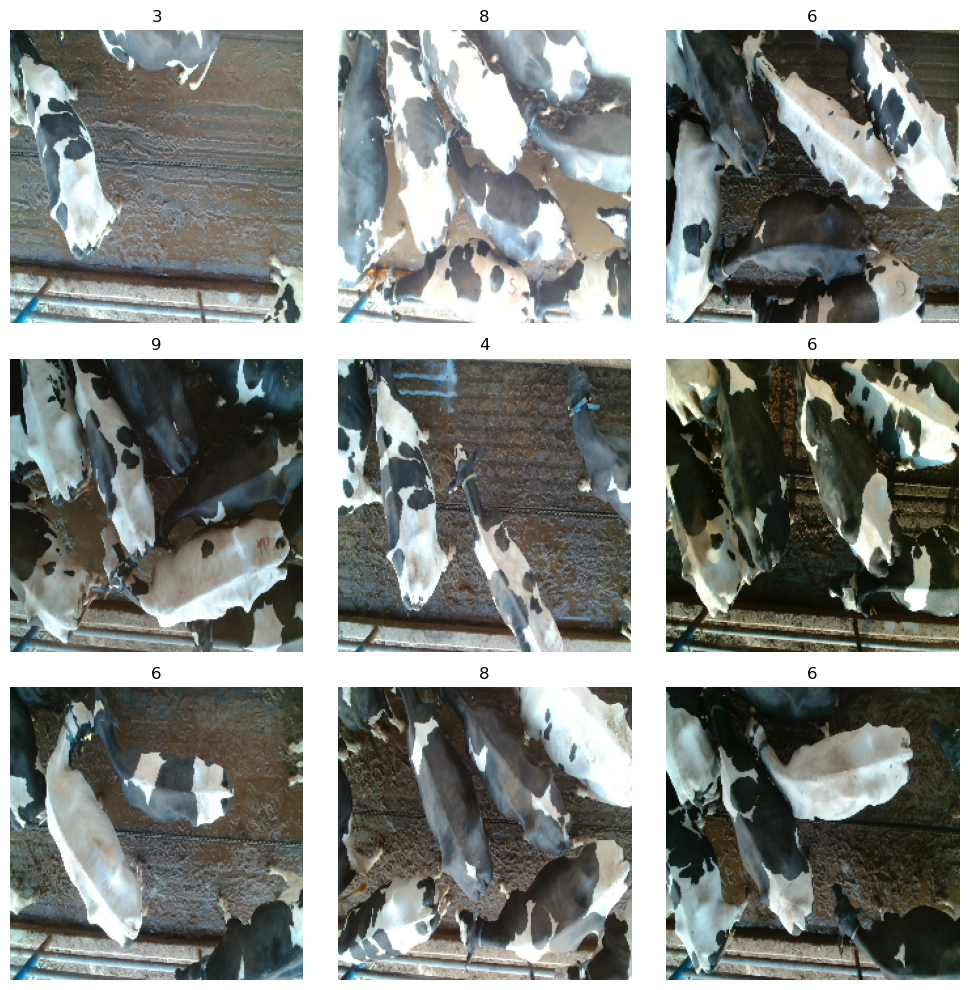

In [119]:
show_batch(train_ds, class_names)

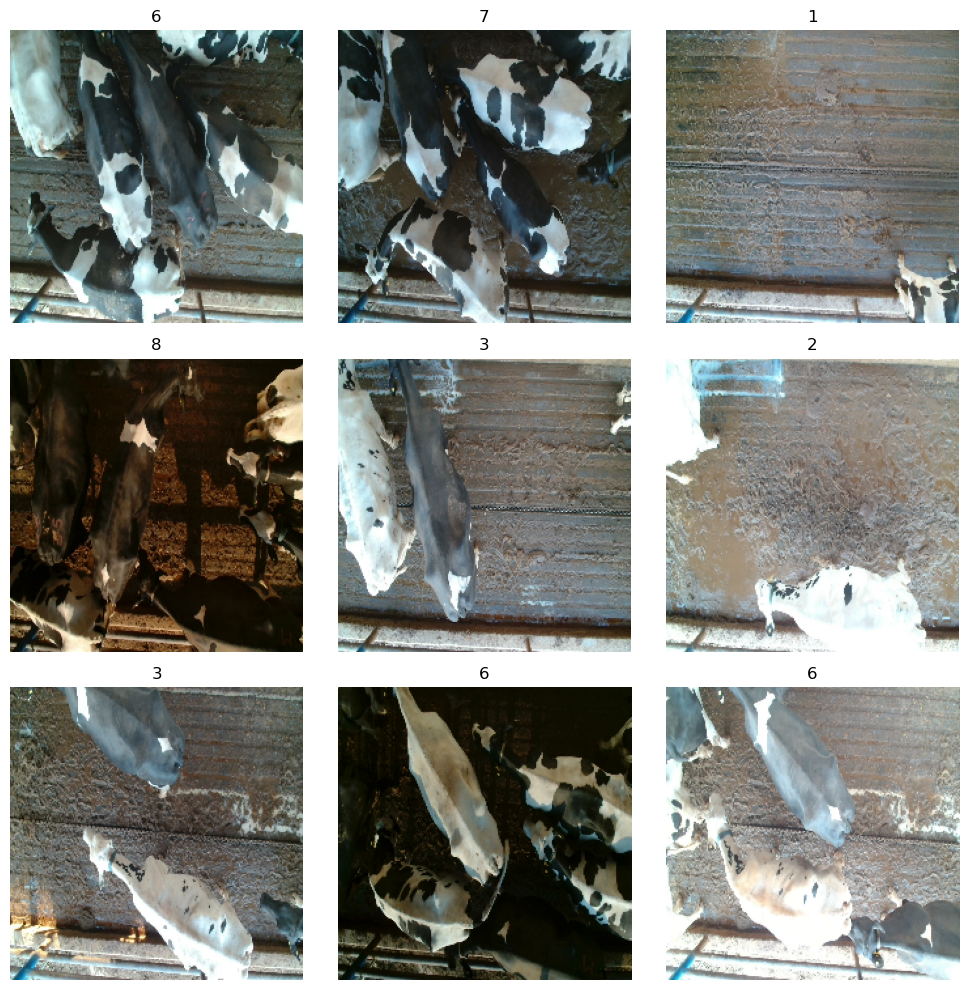

In [120]:
show_batch(val_ds, class_names)

Analyzing class distribution: 100%|██████████| 110/110 [00:00<00:00, 167.84it/s]


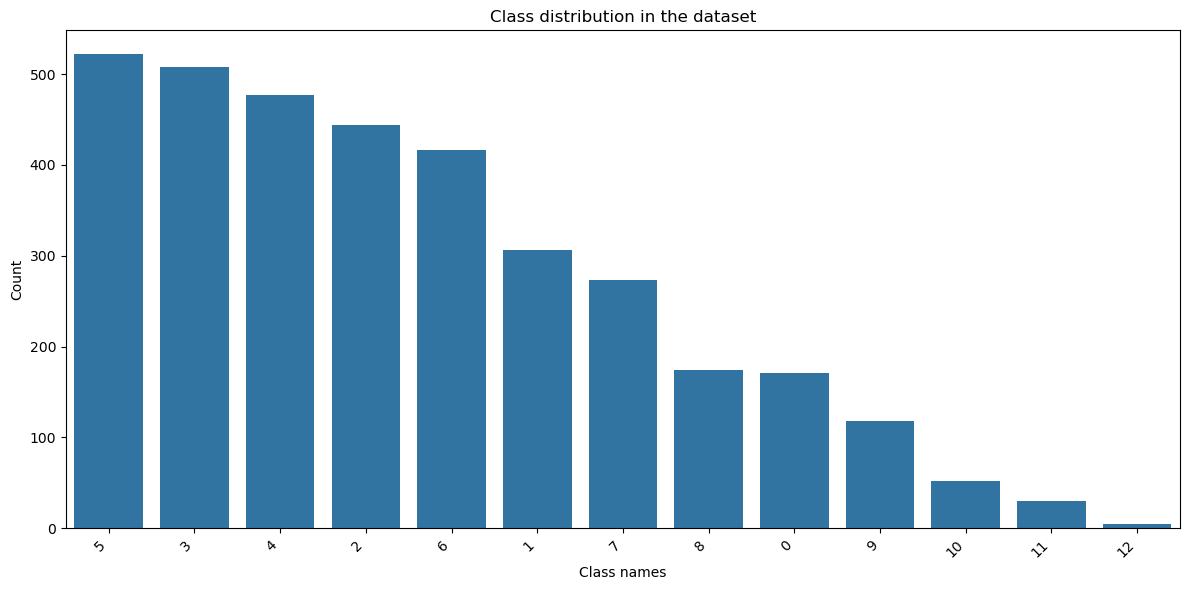

In [121]:
analyze_class_distribution(train_ds, class_names)

Analyzing class distribution: 100%|██████████| 14/14 [00:03<00:00,  4.34it/s]


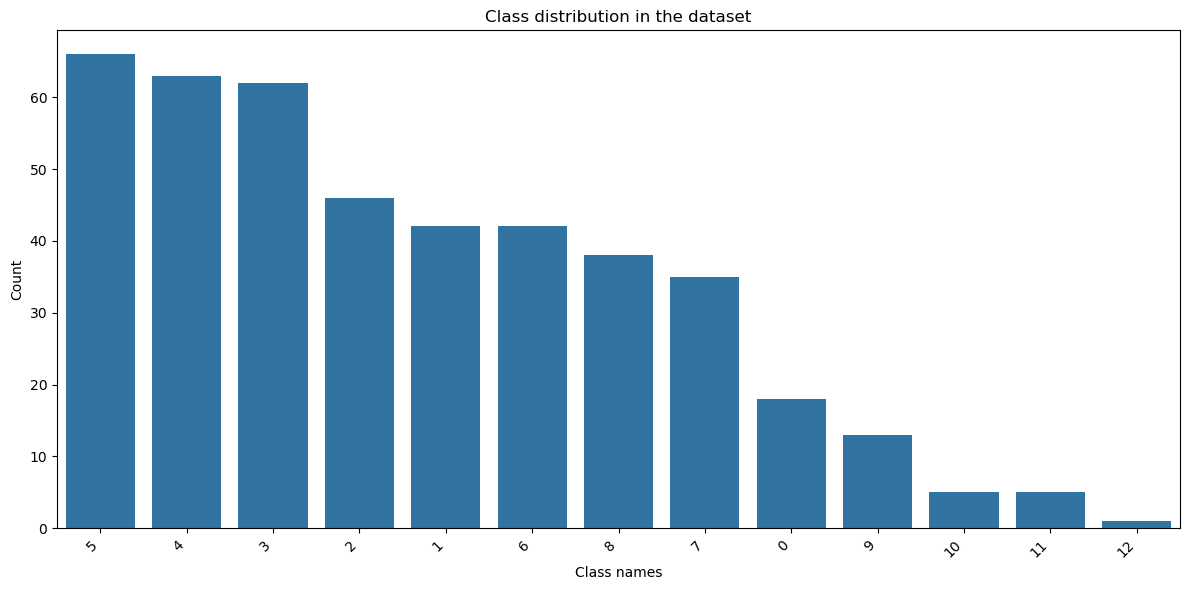

In [122]:
analyze_class_distribution(val_ds, class_names)

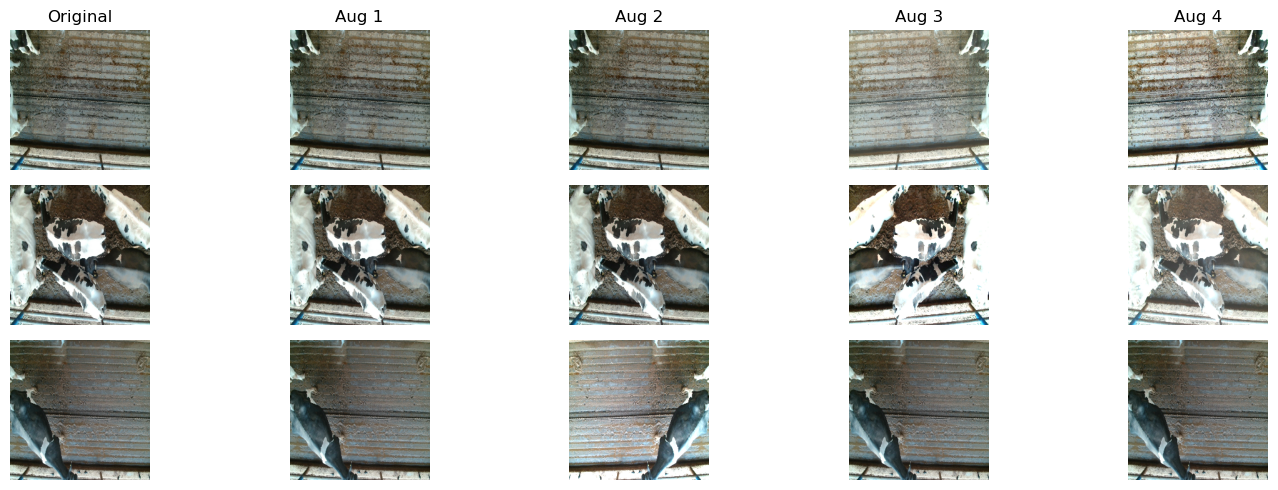

In [123]:
data_augmentation = DataAugmentation(IMG_SIZE)

visualize_data_augmentation(
    dataset=train_ds,
    data_augmentation=data_augmentation,
    num_images=3,
    num_augmentations=4,
)

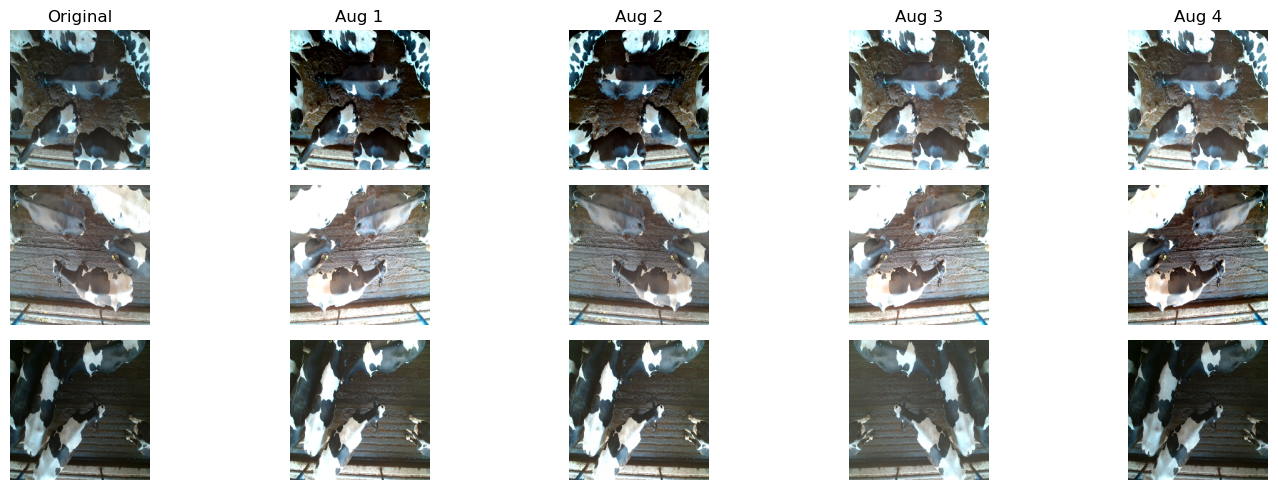

In [124]:
visualize_data_augmentation(
    dataset=val_ds,
    data_augmentation=data_augmentation,
    num_images=3,
    num_augmentations=4,
)

### Creating the base model


In [125]:
config = ModelConfig(
    num_classes=len(class_names),
    input_shape=(224, 224, 3),
    learning_rate=5e-4,
    weight_decay=0.01,
    dropout_rate=0.3,
    train_size=len(train_ds) * 32,
    epochs=50,
)

In [126]:
model = create_cow_counting_model(config, strategy)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │        21,645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,664,525 (48.31 MB)

 Trainable params: 21,645 (84.55 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [127]:
callbacks, model_dir = create_callback(
    experiment_name="night_cattle_classification", patience=10
)

In [128]:
with strategy.scope():
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
    )

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1366 - loss: 4.1265 - sparse_f1_score: 0.0659
Epoch 1: val_accuracy improved from -inf to 0.16972, saving model to models/night_cattle_classification_20241119-123120/checkpoints/best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.1366 - loss: 4.1191 - sparse_f1_score: 0.0660 - val_accuracy: 0.1697 - val_loss: 2.7269 - val_sparse_f1_score: 0.0940 - learning_rate: 1.0000e-04
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.1771 - loss: 2.4924 - sparse_f1_score: 0.1024
Epoch 2: val_accuracy improved from 0.16972 to 0.20413, saving model to models/night_cattle_classification_20241119-123120/checkpoints/best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.1773 - loss: 2.4915 - sparse_f1_score: 0.1025 - val_accuracy: 0.2041 - val_loss: 2.3590 - val_sparse_f1_score: 0.1196 - learning_rate: 1.0000e-04
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accurac


Training Summary:
Best Validation Loss: 1.4551 (Epoch 30)
Best Validation Accuracy: 0.4266
Final Training Accuracy: 0.4399
Final Validation Accuracy: 0.4266
Total Epochs: 30

Overfitting Metrics:
Final Accuracy Difference: 0.0133
Max Accuracy Difference: 0.0622

Plot saved to: models/night_cattle_classification_20241119-123120/checkpoints/training_plot.png


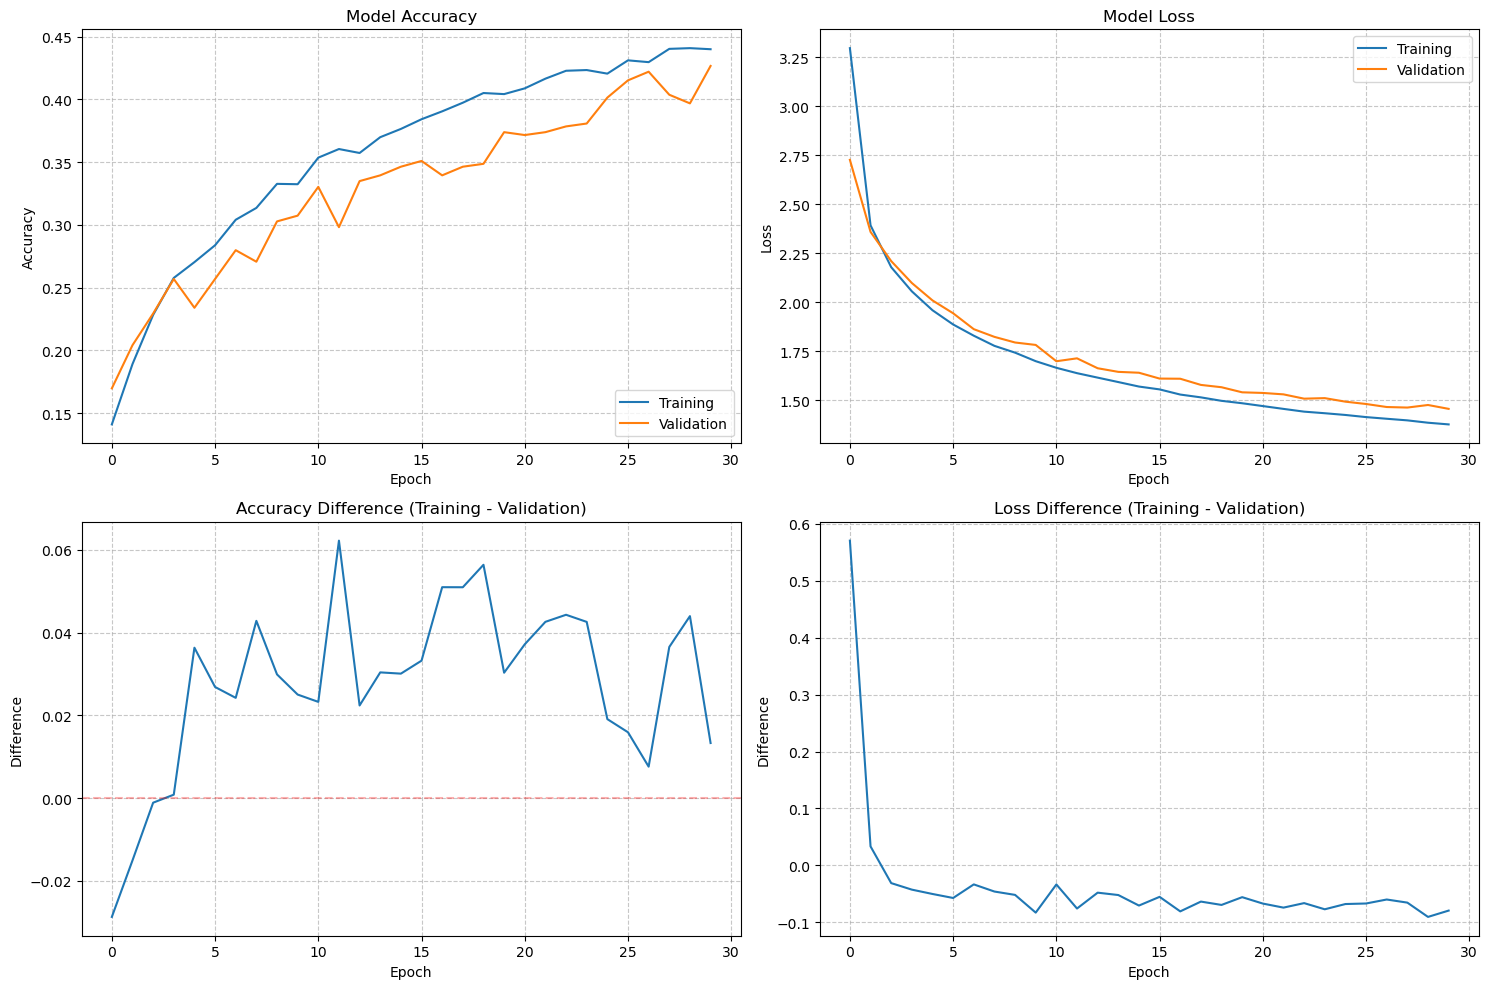

In [129]:
visualize_detailed_history(history, save_path=f"{model_dir}/training_plot.png")

## Prediction


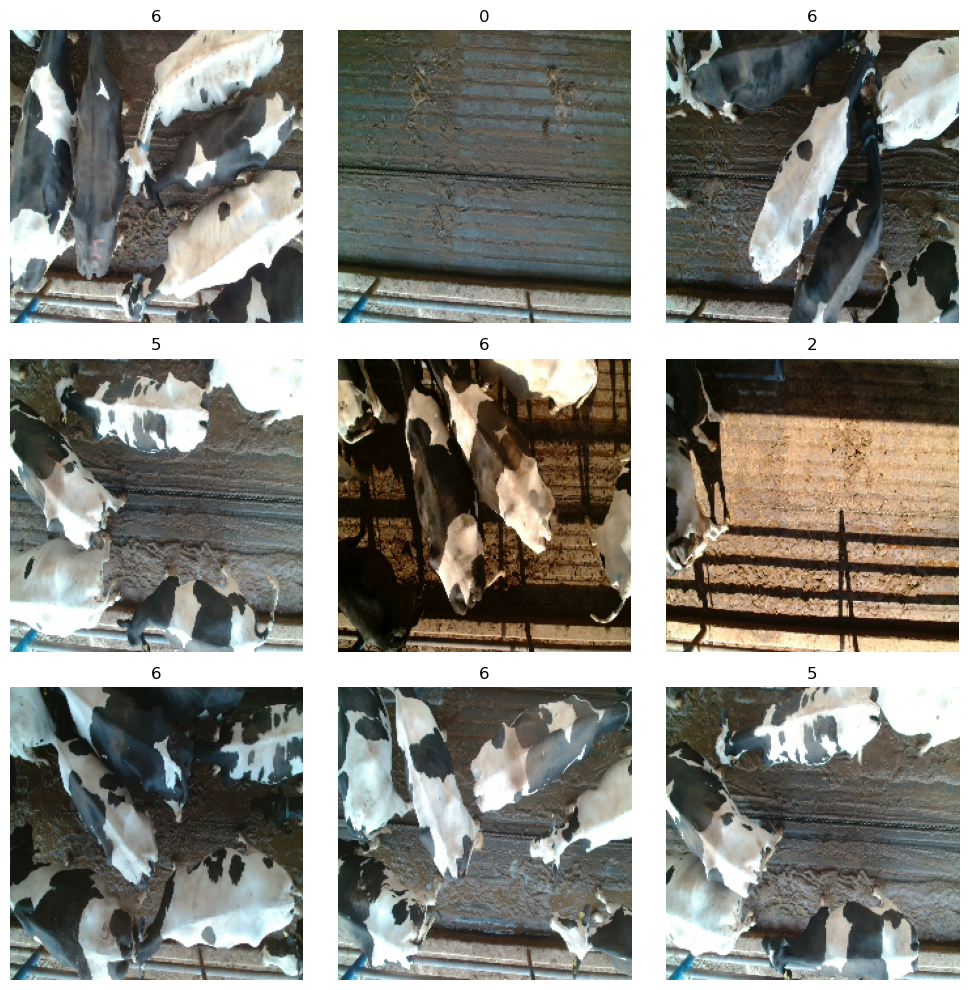

In [130]:
show_batch(test_ds, class_names)

In [131]:
model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.4502 - loss: 1.3827 - sparse_f1_score: 0.2958


[1.4648921489715576, 0.4082568883895874, 0.2958957850933075]

In [132]:
f1_scores = {
    "epoch": list(range(1, len(history.history["sparse_f1_score"]) + 1)),
    "train_f1": history.history["sparse_f1_score"],
    "val_f1": history.history["val_sparse_f1_score"],
}

df = pd.DataFrame(f1_scores)
model_name = "ResNet50V2_classification_night"

df.to_csv(f"{model_dir}/{model_name}_f1_scores.csv", index=False)